# Tutorial 7a: Time series / Smoothing

*This tutorial was generated from a Jupyer notebook.  You can download the notebook [here](t7a_time_series.ipynb).*


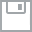
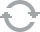
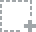
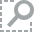
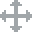
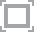
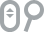
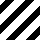
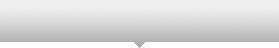
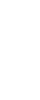
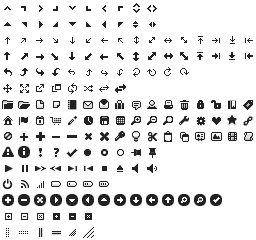
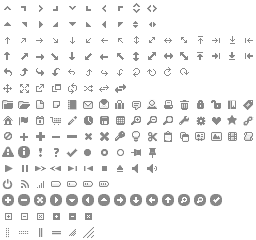
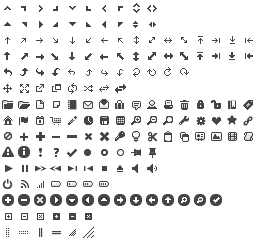
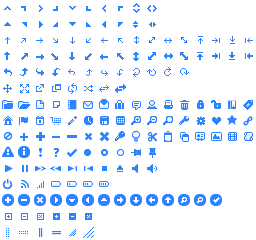
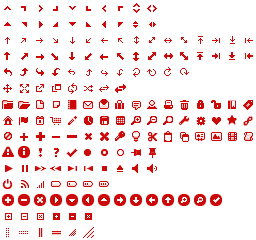
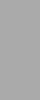
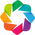
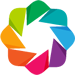

In [1]:
import itertools
import warnings

# Our numerical workhorses
import numpy as np
import pandas as pd
import scipy.signal
import scipy.special
import scipy.stats as st

# BE/Bi 103 utilities
import bebi103

# Import plotting tools
import matplotlib.pyplot as plt
import seaborn as sns
import corner

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('darkgrid', rc=rc)

# Import Bokeh modules for interactive plotting
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting

# Display graphics in this notebook
bokeh.io.output_notebook()

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In this tutorial, we will work with a specific type of data, **time series data**, in which we have data of the for $(t, x(t))$, where $t$ represents sequential time.  Importantly, $x$ can be correlated in time, so our assumptions about data being uncorrelated (which enabled us to write down likelihoods as products of independent distributions) no longer hold.  There is a rich literature on time series analysis, and we will only dip our toe into the surface here.

We will focus on a few aspects that often come up in time series analysis in biology.  First, we will learn how to filter signals, something we have already briefly touched on when we looked that the fMRI data.  Then, we will work on techniques for extracting features out of a time trace.  For this last challenge, we will use some ad hoc methods.

## The data set
The data from from Markus Meister's group from Dawna Bagherian and Kyu Lee, two students from last year's course.  They put electrodes in the retinal cells of a mouse and measured voltage.  From the time trace of voltage, they can detect and characterize spiking events.  Our goal today in this tutorial is to detect these events from a time trace of voltage from a mouse retinal cell and determine the probability distribution for inter-spike waiting times.  This particular mouse had no stimuli; it was just held in constant light.

### Prepping the data
We'll start by loading in the data set.  The units of time are milliseconds and the units of the voltage are microvolts.

In [2]:
# Load in DataFrame
df = pd.read_csv('../data/bagherian_et_al/no_stimulation.csv', comment='#', 
                 names=['t (ms)', 'V (µV)'])

# Take a look
df.head()

,t (ms),V (µV)
0,303.96,-18.44
1,304.00,0.94
2,304.04,-6.35
3,304.08,-14.38
4,304.12,-0.52


It will be convenient to reset time to start at zero, so let's subtract the minimum time.  We'll also convert our units to seconds.

In [3]:
# Start at zero
df['t (ms)'] -= df['t (ms)'].min()

# Convert to seconds
df['t (ms)'] /= 1000
df = df.rename(columns={'t (ms)': 't (s)'})

Let's see how long the trace is.

In [4]:
print('n_samples =', len(df))
print(' max time =', df['t (s)'].max(), 's') 

n_samples = 2682401
 max time = 107.296 s


Whew!  Over 2 million samples over almost two minutes.  Let's get the sampling rate, and do a quick check to make sure it's uniform.  (By the way, these are good checks to do when validating data.)

In [5]:
# Get sampling rate from first two points
inter_sample_time = df['t (s)'][1] - df['t (s)'][0]
print('inter_sample_time =', inter_sample_time, 's')

# Check to make sure they are all the same
print('All the same?:', np.allclose(np.diff(df['t (s)']), inter_sample_time))

inter_sample_time = 4e-05 s
All the same?: True


Good!  So, let's save our sampling rate in units of Hz.

In [6]:
sampling_freq =  1 / inter_sample_time

### Exploring the trace
We want to get a quick look at the data, so we will use Bokeh to enable in-browser exploration.  Since the time trace is very long, we will only look at the 20,000 samples.

In [7]:
p = bokeh.charts.Line(df.loc[10000:30000,:], x='t (s)', y='V (µV)', 
                      color='slateblue')
bokeh.io.show(p)

In the zoomed out view, we can see spiking events as obvious drops in the voltage.  When we zoom in, we can see what an individual spike looks like.  We'll reproduce it here.

In [8]:
inds = (0.675 < df['t (s)']) & (df['t (s)'] < 0.69)
p = bokeh.charts.Line(df.loc[inds,:], x='t (s)', y='V (µV)', color='slateblue')
bokeh.io.show(p)

## The signal in the frequency domain
We are used to looking at time series data in the time domain, but this is only one way to look at it.  Another way is in the **frequency domain**.  We will not go into the mathematical details here, but talk very loosely to get a feel for what it means to represent data in the frequency domain.  You can imagine that a signal can be represented by the sum of sine waves of different frequency.  High frequency aspects of the signal oscillate rapidly, while low frequency aspects of the signal vary slowly in time.  We can represent a signal by the magnitudes that each frequency contributes to the total signal.  So, instead of plotting a signal versus $t$, we can plot the magnitudes, or **Fourier coefficients**, of each frequency versus the frequency, $f$.  A plot like this is called a periodogram, and is useful to see what is present in the signal.

We can do much more with these magnitudes corresponding to frequencies.  Say we wanted to filter out high frequency parts of the signal because they constitute noise.  We could just go to the frequency domain, set the magnitudes for high frequencies to zero, and then go back to the time domain.

The **Fourier transform** is a useful mathematical tool to take us to the frequency domain and back, via the inverse Fourier transform.  The **fast Fourier transform**, or FFT, is a very fact algorithm to do this, and it is implement in NumPy and SciPy.  Furthermore, the `scipy.signal` module has many convenient functions for filtering in the frequency domain.  We will make use of a **Butterworth filter**, which is one of the simplest frequency domain filters available.

### The periodogram
Let's see what frequencies are present in our signal by computing the periodogram.  We do this by getting the frequencies associated with the Fourier coefficients using `np.fft.fftfreq()` and then computing the **power spectral density**, which is just the square of the magnitude of the Fourier coefficients.  We can then plot the result.  For reasons we will not get in to here, we will only consider positive frequencies, since the Fourier coefficients for the negative frequencies are symmetric.  Note that we could generate the periodogram automatically using

    f, psd = scipy.signal.periodogram(df['V (µV)'], fs=sampling_freq)
    
but this is much slower, due to all the bells and whistles included in `scipy.signal`.

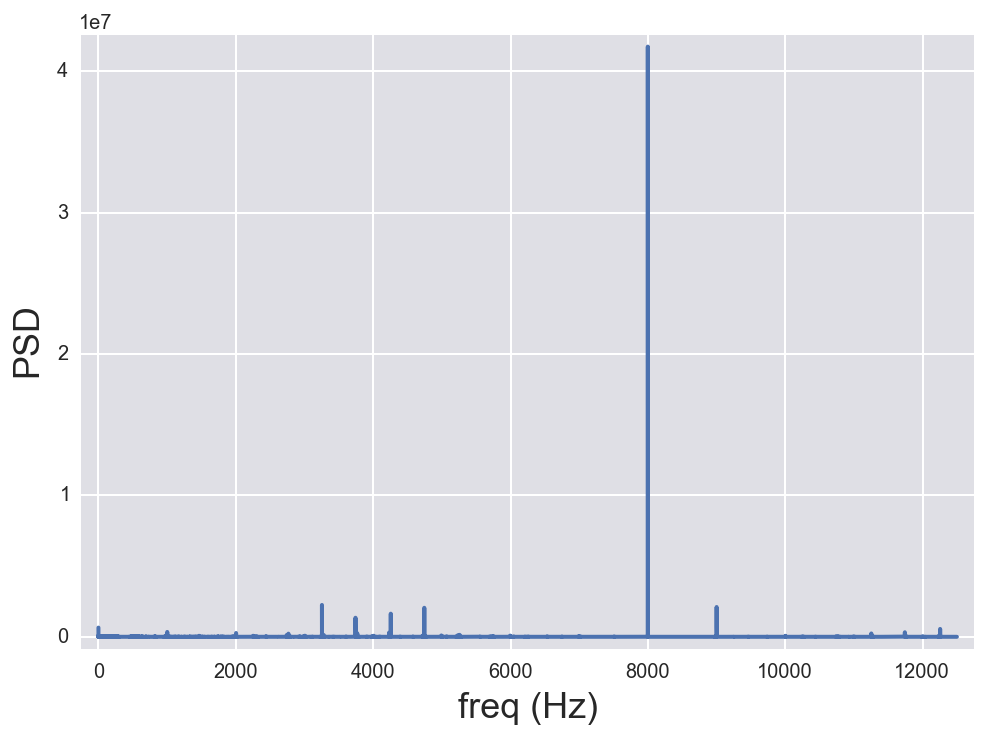

In [9]:
# Determine frequencies
f = np.fft.fftfreq(len(df)) * sampling_freq

# Compute power spectral density
psd = np.abs(np.fft.fft(df['V (µV)'].values))**2 / len(df)

# Make plot
plt.plot(f[f>=0], psd[f>=0])
plt.xlabel('freq (Hz)')
plt.ylabel('PSD')
plt.margins(0.02)

Note that we have frequencies up to 12,500 Hz.  This is the **Nyquist frequency**, which is half the sampling frequency, which is the highest frequency that can be coded at a given sampling rate (in our case, 25,000 Hz).

There is a big peak at 8000 Hz, which corresponds to the dominant frequency in the signal.  This is high-frequency noise, but it is important to keep these frequencies because the signal in spikes undergoes a rapid change in just a fraction of a millisecond.  So, we probably want to keep the high frequencies.

The very low frequency peak at $f = 0$ corresponds to the constant, or DC, signal.  That obviously also does not include spikes.  There is also some low frequency oscillation, which are clearly not related to spiking.  If we want to detect spikes by setting a threshold voltage, though, it is important to filter out these low frequency variations.

As we saw from looking at the plots, a spike occurs over about 10 or 20 ms, which would be captured by sampling at about 200 Hz ($2 / 0.01 \text{ s}$, according to the Nyquist sampling theorem).  So, to make sure we get good resolution on the spikes, we should be sure not to filter out frequencies that are too close to 100 Hz.

### Butterworth filter: a frequency-based filter
There are lots and lots of filters available, but we will use a simple [Butterworth filter](https://en.wikipedia.org/wiki/Butterworth_filter).  We won't go into the theory of filters, transfer functions, etc., here, but will get a graphical idea of how a Butterworth filter works.  A Butterworth filter is a **band pass** filter, meaning that it lets certain bands of frequency "pass" and be included in the filtered signal.  We want to construct a highpass filter because we just want to filter out the low frequencies.

We construct a Butterworth filter using `scipy.signal.butter()`.  This function returns coefficients on polynomials for the numerator and denominator of a Butterworth filter, which you can read about on the [Wikipedia page](https://en.wikipedia.org/wiki/Butterworth_filter).  We have to specify the order of the polynomials (we'll use third order) and the cutoff frequency, which defines the frequency below which modes are cut off.  The cutoff frequency has to be in units of the Nyquist frequency.  We will put out cutoff at 50 Hz.

In [10]:
# Compute Nyquist frequency
nyquist_freq = sampling_freq / 2

# Design a butterworth filter
b, a = scipy.signal.butter(3, 100 / nyquist_freq, btype='high')

Let's look at what frequencies get through this filter (the so-called **frequency response**).  We can get the frequencies (in units of $\pi/f_\text{Nyquist}$, or radians/sample) and the the response using `scipy.signal.freqz()`.

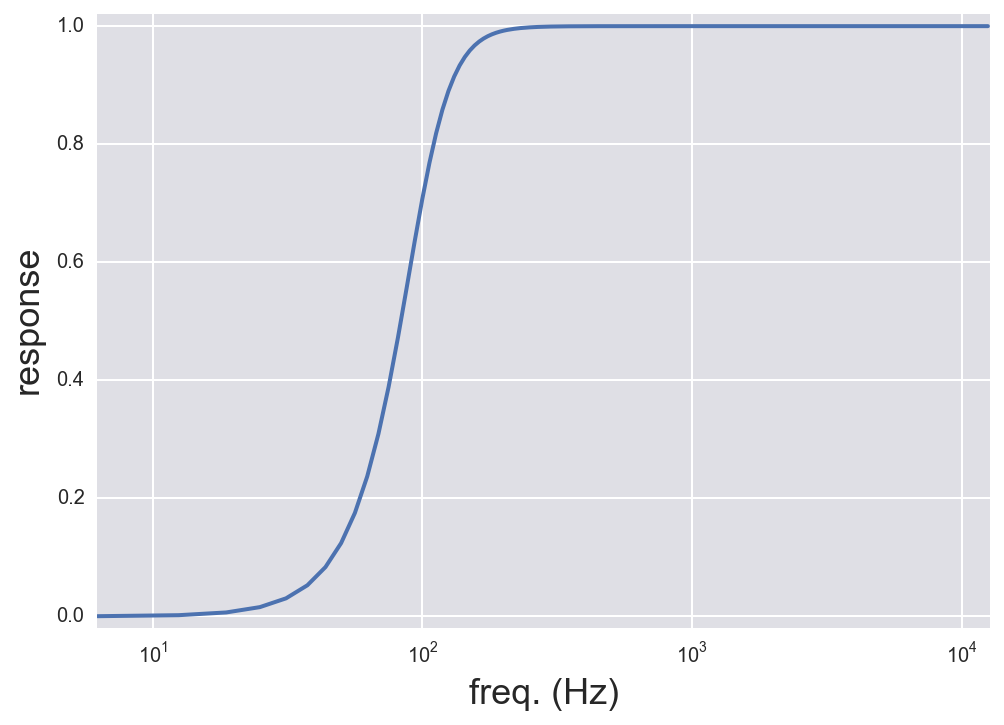

In [11]:
# Get frequency response curve
w, h = scipy.signal.freqz(b, a, worN=2000)

# Make plot
plt.semilogx((nyquist_freq / np.pi) * w, abs(h))
plt.xlabel('freq. (Hz)')
plt.ylabel('response')
plt.margins(0.02)

So, we will block out frequencies below about 50 Hz and let high frequencies pass through.  Let's filter the voltages and look at the result.

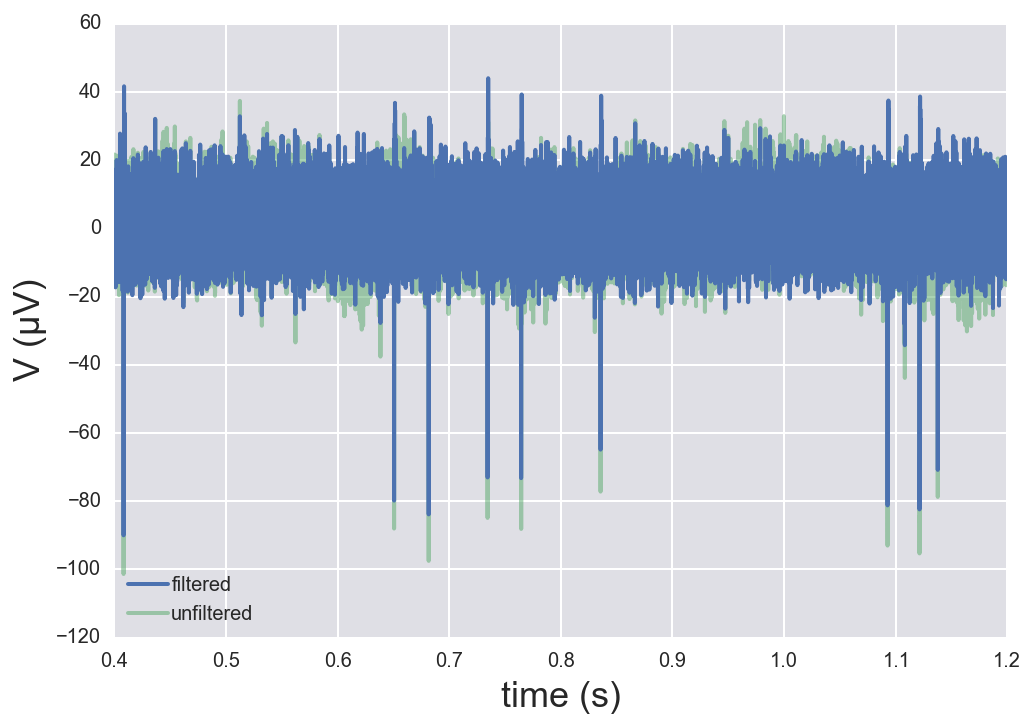

In [12]:
# Filter data
df['V filtered (µV)'] = scipy.signal.lfilter(b, a, df['V (µV)'])

# Plot the result, overlaying filtered and unfiltered
plt.plot(df['t (s)'][10000:30000], df['V filtered (µV)'][10000:30000], '-', 
         zorder=2, label='filtered')
plt.plot(df['t (s)'][10000:30000], df['V (µV)'][10000:30000], '-', 
         alpha=0.5, zorder=1, label='unfiltered')
plt.xlabel('time (s)')
plt.ylabel('V (µV)')
plt.legend(loc='lower left')

The filtering did a good job of limited longer time scale variations while keeping the spikes intact.

## Finding the spikes
We'll now use our filtered trace to locate the spikes.  Our goal is to find the spikes, store a neighborhood around the spike, and then find the position of the spike to sub-sampling accuracy.

### Locating spikes
To locate the spikes, we will search for places where the signal dips below a threshold and then rises up above it again.  This will mark boundaries of the spike, and we will then keep half a millisecond of samples on the left side of the threshold crossing and 2 milliseconds on the right.

In [13]:
# Threshold below which spike has to drop (in µV)
thresh = -40

# Amount of time in seconds to keep on either side of spike
time_window_left = 0.0005
time_window_right = 0.002

# Number of samples to keep on either side of spike
n_window_left = int(time_window_left * sampling_freq)
n_window_right = int(time_window_right * sampling_freq)

# DataFrame to store spikes
df_spike = pd.DataFrame(columns=['spike', 't (s)', 'V (µV)'])

# Use a NumPy array for speed in looping
V = df['V filtered (µV)'].values

# Initialize while loop
i = 1
spike = 0
while i < len(df):
    if V[i] < thresh:
        # Found a spike, get crossings
        cross_1 = i
        while V[i] < thresh:
            i += 1
        cross_2 = i
        
        # Store perintent quantities in DataFrame
        t_in = df['t (s)'][cross_1-n_window_left:cross_2+n_window_right]
        V_in = df['V (µV)'][cross_1-n_window_left:cross_2+n_window_right]
        data={'t (s)': t_in,
              'V (µV)': V_in,
              'spike': spike * np.ones_like(t_in, dtype=int)}
        df_add = pd.DataFrame(data)
        df_spike = pd.concat((df_spike, df_add))

        spike += 1

    i += 1

Now that we have found the spikes, let's plot them all on top of each other to ascertain their shape.

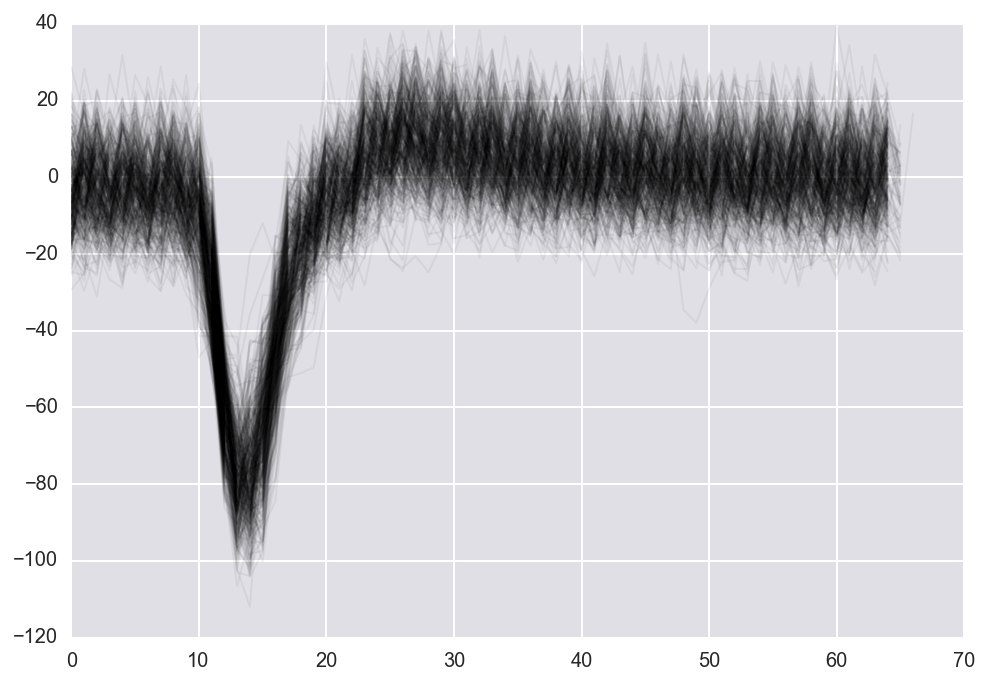

In [14]:
for spike in df_spike['spike'].unique():
    inds = df_spike['spike'] == spike
    plt.plot(np.arange(inds.sum()), df_spike['V (µV)'][inds], lw=1, alpha=0.05,
             color='black')

### A smooth interpolant for the spike potential
We would like to describe the spike with a smooth function.  In doing this, we can estimate the location of the bottom of the spike to greater accuracy than dictated by the sampling rate.  We call a smooth curve that passes through the noisy data and **interpolant**.

Let's look at a single spike as we develop the interpolant.

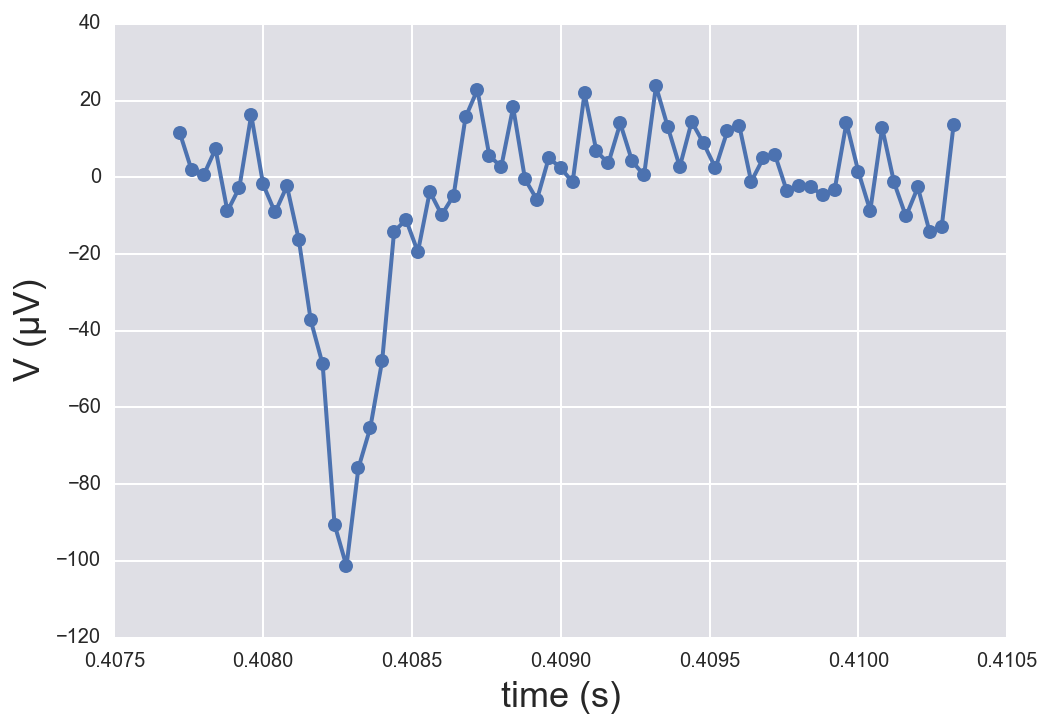

In [15]:
# Pull out 0th spike
spike = 0
ts = df_spike[df_spike['spike']==spike]['t (s)'].values
Vs = df_spike[df_spike['spike']==spike]['V (µV)'].values

# Plot the spike
plt.plot(ts, Vs, 'o-')
plt.xlabel('time (s)')
plt.ylabel('V (µV)')

We will consider several ways to get a smooth interpolant.

#### Smoothing with basis functions (splines)

We'll now look at another smoothing strategy.  A function $f(x)$ (or data) can generally be written as an expansion of $M$ orthogonal **basis functions** $h_m$, such that

\begin{align}
f(x) = \sum_{m=1}^M \beta_m\,h_m(x),
\end{align}

where $\beta_m$ are coefficients.  Examples of basis functions you may be familiar with are sines/cosines (used to construct a Fourier series), Legendre polynomials, spherical harmonics, etc.  The idea behind smoothing with basis functions is to control the complexity of $f(x)$ by restricting the number of basis functions or selecting certain basis functions to use.  This restricted $f(x)$, being less complex than the data, is smoother.

A commonly used set of basis function are cubic polynomials.  An approximation from this procedure is called a **spline**.  If we have $k$ joining points of cubic functions (called *knots*), the data are represented with $k$ basis functions.

The `scipy.interpolate` modules has spline tools.  Importantly, it selects the number of knots to use until a smoothing condition is met.  This condition is defined by

\begin{align}
\sum_{i\in D} \left[w_i(y_i - \hat{y}(x_i))\right]^2 \le s,
\end{align}

where $w_i$ is the weight we wish to assign to data point $i$, and $\hat{y}(x_i)$ is the smoothed function at $x_i$.  We will take all $w_i$'s to be equal in our analysis.  A good rule of thumb is to choose

\begin{align}
s = f\sum_{i\in D} y_i^2,
\end{align}

where $f$ is roughly the fractional difference between the rough and smooth curves.

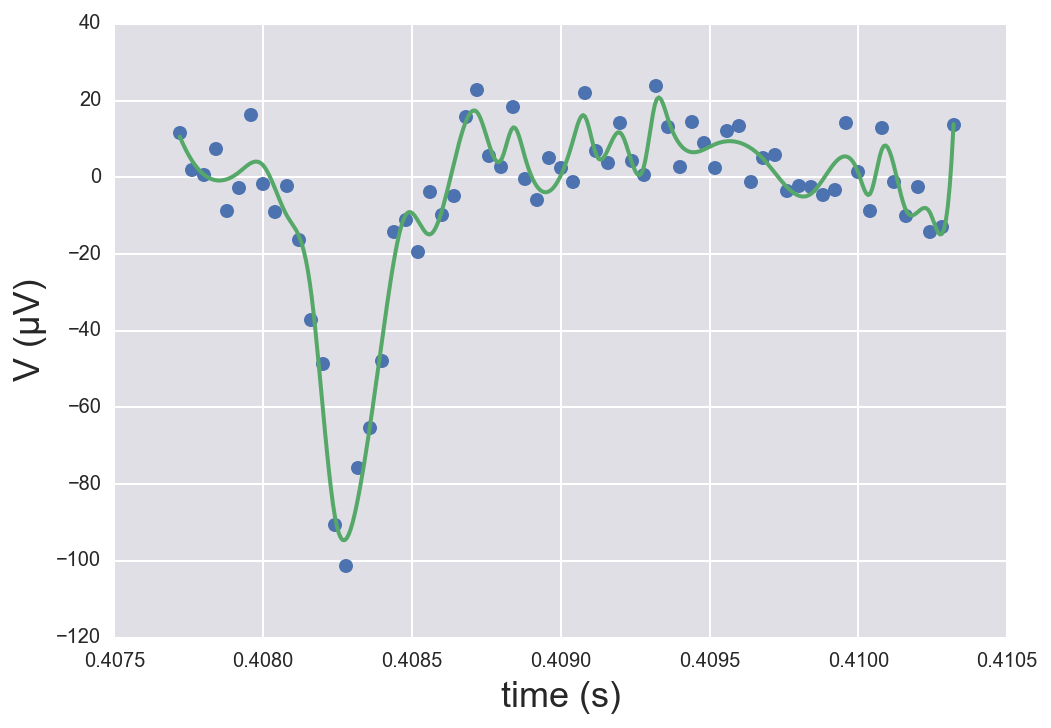

In [16]:
# Determine smoothing factor from rule of thumb (use f = 0.05)
smooth_factor = 0.05 * (Vs**2).sum()

# Set up an scipy.interpolate.UnivariateSpline instance
spl = scipy.interpolate.UnivariateSpline(ts, Vs, s=smooth_factor)

# spl is now a callable function
ts_spline = np.linspace(ts[0], ts[-1], 400)
Vs_spline = spl(ts_spline)

# Plot results
plt.plot(ts, Vs, 'o')
plt.plot(ts_spline, Vs_spline)
plt.xlabel('time (s)')
plt.ylabel('V (µV)')

Perhaps we chose our smoothing factor to be too small.  But a better explanation for the windy path of the spline curve is that the spike is highly localized and then imposes a large variation on the data.  It might be better to only fit a spline in the close neighborhood of the spike.

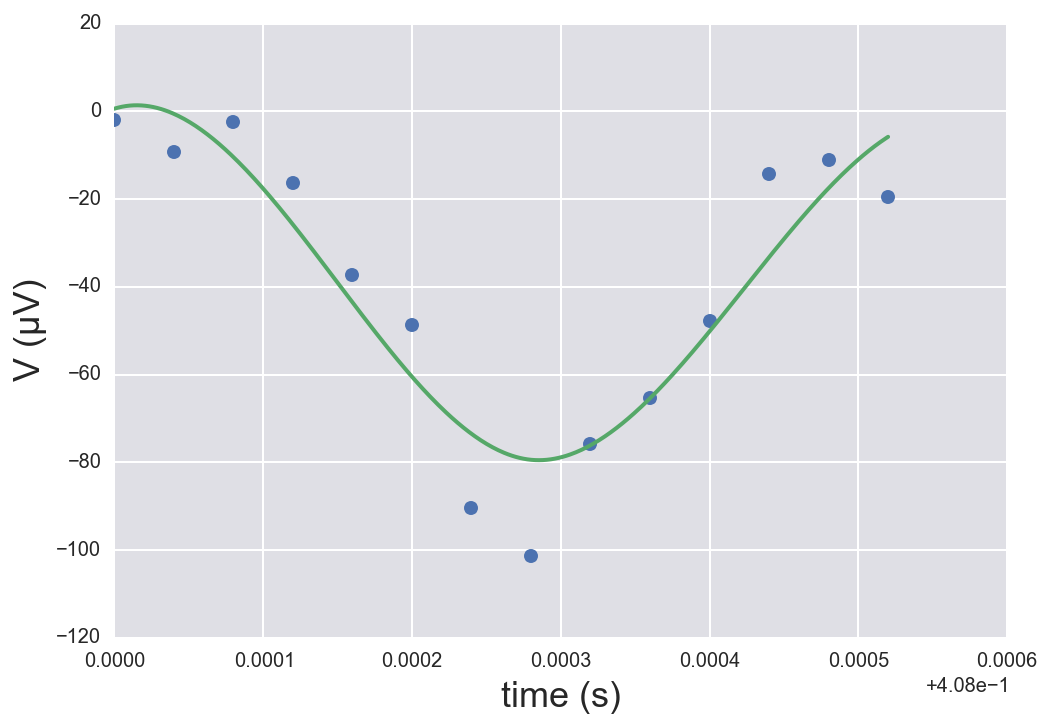

In [17]:
minind = np.argmin(Vs)
ts_short = ts[minind-7:minind+7]
Vs_short = Vs[minind-7:minind+7]

smooth_factor = 0.05 * (Vs_short**2).sum()
spl = scipy.interpolate.UnivariateSpline(ts_short, Vs_short, s=smooth_factor)
ts_spline = np.linspace(ts_short[0], ts_short[-1], 400)
Vs_spline = spl(ts_spline)

# Plot results
plt.plot(ts_short, Vs_short, 'o')
plt.plot(ts_spline, Vs_spline)
plt.xlabel('time (s)')
plt.ylabel('V (µV)')

#### Kernel-based smoothing

Another option for smoothing is a **kernel-based method**.  We will use a **Nadaraya-Watson kernel estimator**, which is essentially a weighted average of the data points.  

When we have a high sampling rate, the extra fine resolution often just gives the noise.  We could do a sliding average over the data.  We already performed this operation in Tutorial 2 when we were looking at the fish sleep data.  I will write this process more concretely.  For ease of notation, we arrange our data points in time, i.e., index $i+1$ follows $i$ in time, with a total of $n$ data point.  For data point $(x_i, y_i)$, we get a smoothed values $\hat{x}_i$ by

\begin{align}
\hat{y}(x_0) = \frac{\sum_{i=1}^n K_\lambda(x_0, x_i)\, y_i}{\sum_{i=1}^n K_\lambda(x_0,x_i)}
\end{align}

where $K_\lambda(x_0, x_i)$ is the **kernel**, or weight.  If we took each data point to be the mean of itself and its 10 nearest-neighbors, we would have (neglecting end effects)

\begin{align}
K_\lambda(x_j, x_i) = \left\{\begin{array}{cl}
\frac{1}{11} & \left|i - j\right| \le 5 \\[1mm]
0 & \text{otherwise}.
\end{array}
\right.
\end{align}

Commonly used Kernels are the Epanechnikov quadratic kernel, the tri-cube kernel, and the Gaussian kernel.  We can write them generically as

\begin{align}
K_\lambda(x_0, x_i) &= D\left(\frac{\left|x_i-x_0\right|}{\lambda}\right)
\equiv D(t), \\[1mm]
\text{where } t &= \frac{\left|x_i-x_0\right|}{\lambda}.
\end{align}

These kernels are

\begin{align}
\text{Epanechnikov:}\;\;\;\;\; D &= \left\{\begin{array}{cl}
\frac{3}{4}\left(1 - t^2\right) & |t| \le 1 \\[1mm]
0 & \text{otherwise}
\end{array}\right. \\[5mm]
\text{tri-cube:}\;\;\;\;\;D&=\left\{\begin{array}{cl}
\left(1 - \left|t\right|^3\right)^3 & |t| \le 1 \\[1mm]
0 & \text{otherwise}
\end{array}\right. \\[5mm]
\text{Gaussian:}\;\;\;\;\;D &= \mathrm{e}^{-t^2}.
\end{align}

Let's code up functions for these kernels.

In [18]:
# Define our kernels
def epan_kernel(t):
    """
    Epanechnikov kernel.
    """
    return np.logical_and(t > -1.0, t < 1.0) * 3.0 * (1.0 - t**2) / 4.0

def tri_cube_kernel(t):
    """
    Tri-cube kernel.
    """
    return np.logical_and(t > -1.0, t < 1.0) * (1.0 - abs(t**3))**3

def gauss_kernel(t):
    """
    Gaussian kernel.
    """
    return np.exp(-t**2 / 2.0)

Now we can compare the respective kernels to get a feel for how the averaging goes.

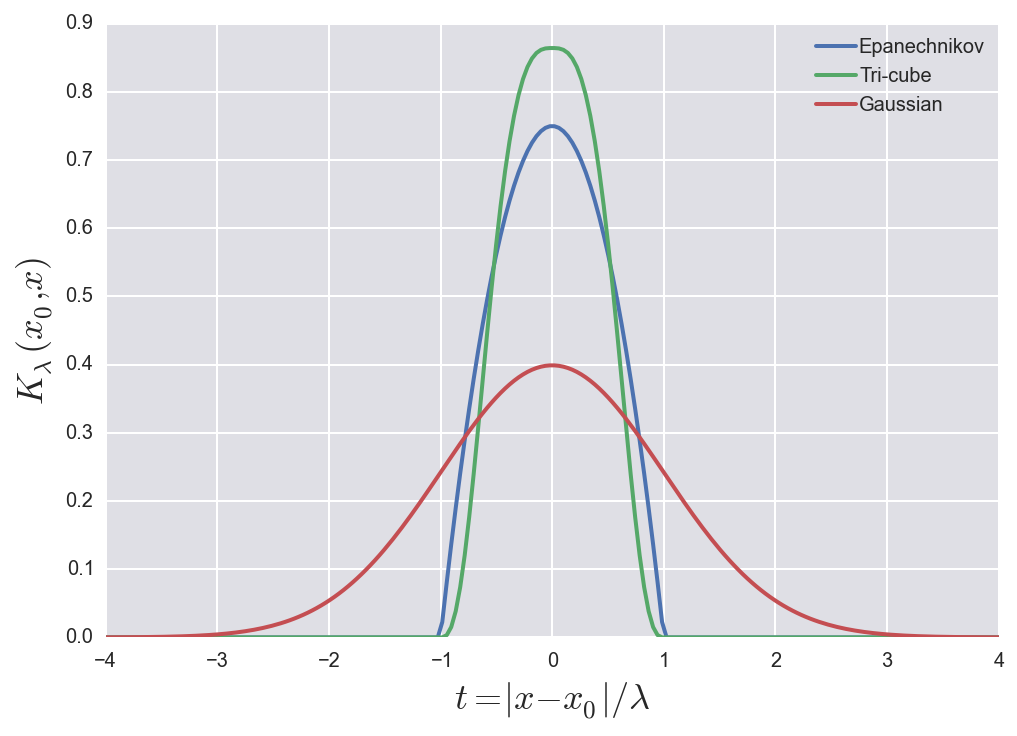

In [19]:
# Set up time points
t = np.linspace(-4.0, 4.0, 200)
dt = t[1] - t[0]

# Compute unnormalized kernels
K_epan = epan_kernel(t)
K_tri_cube = tri_cube_kernel(t)
K_gauss = gauss_kernel(t)

# Adjust to approximately integrate to unity for ease of comparison
K_epan /= K_epan.sum() * dt
K_tri_cube /= K_tri_cube.sum() * dt
K_gauss /= K_gauss.sum() * dt

plt.plot(t, K_epan, '-', label='Epanechnikov')
plt.plot(t, K_tri_cube, '-', label='Tri-cube')
plt.plot(t, K_gauss, '-', label='Gaussian')
plt.legend(loc='upper right')
plt.xlabel('$t = |x-x_0|/\lambda$')
plt.ylabel('$K_\lambda(x_0, x)$');

From the scale of the $x$-axis in this plot, we see that the parameter $\lambda$ sets the width of the smoothing kernel.  The bigger $\lambda$ is, the stronger the smoothing and the more fine detail will be averaged over.  For this reason, $\lambda$ is sometimes called the **bandwidth** of the kernel.  The Gaussian kernel is broad and has no cutoff like the Epanechnikov or tri-cube kernels.  If therefore uses all of the data points.

We will now write a function to give the smoothed value of a function for a given kernel using Nadaraya-Watson.

In [20]:
def nw_kernel_smooth(x_0, x, y, kernel_fun, lam):
    """
    Gives smoothed data at points x_0 using a Nadaraya-Watson kernel 
    estimator.  The data points are given by NumPy arrays x, y.
        
    kernel_fun must be of the form
        kernel_fun(t), 
    where t = |x - x_0| / lam
    
    This is not a fast way to do it, but it simply implemented!
    """
    
    # Function to give estimate of smoothed curve at single point.
    def single_point_estimate(x_0_single):
        """
        Estimate at a single point x_0_single.
        """
        t = np.abs(x_0_single - x) / lam
        return np.dot(kernel_fun(t), y) / kernel_fun(t).sum()
    
    # If we only want an estimate at a single data point
    if np.isscalar(x_0):
        return single_point_estimate(x_0)
    else:  # Get estimate at all points
        y_smooth = np.empty_like(x_0)
        for i in range(len(x_0)):
            y_smooth[i] = single_point_estimate(x_0[i])
        return y_smooth

All right, we're all set.  Let's try applying some kernels to our spike

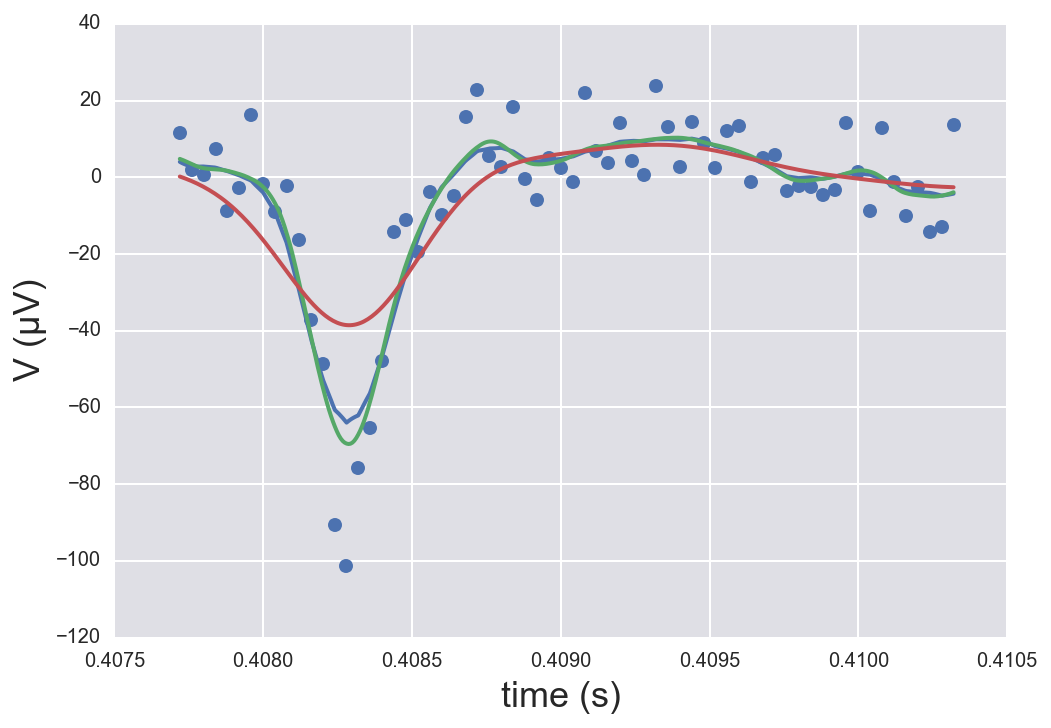

In [21]:
# Specify time points
ts_kernel = np.linspace(ts[0], ts[-1], 400)

# Averaging window (0.2 ms)
lam = 0.0002

# Compute smooth curves with kernel
Vs_epan = nw_kernel_smooth(ts_kernel, ts, Vs, epan_kernel, lam)
Vs_tri_cube = nw_kernel_smooth(ts_kernel, ts, Vs, tri_cube_kernel, lam)
Vs_gauss = nw_kernel_smooth(ts_kernel, ts, Vs, gauss_kernel, lam)

# Plot results
plt.plot(ts, Vs, 'o')
plt.plot(ts_kernel, Vs_epan, color=sns.color_palette()[0])
plt.plot(ts_kernel, Vs_tri_cube, color=sns.color_palette()[1])
plt.plot(ts_kernel, Vs_gauss, color=sns.color_palette()[2])
plt.xlabel('time (s)')
plt.ylabel('V (µV)')

All of these dull the spike.  In fact, this is generally what you will find with smoothing methods.

#### The simple option
Why don't we just fit a parabola to the bottom three points and then compute the minimum that way?  If we approximate $V(t) = at^2 + bt + c$ at the bottom of the spike, the minimum is at $t = -b/2a$.  We can do this easily using `np.polyfit()`.

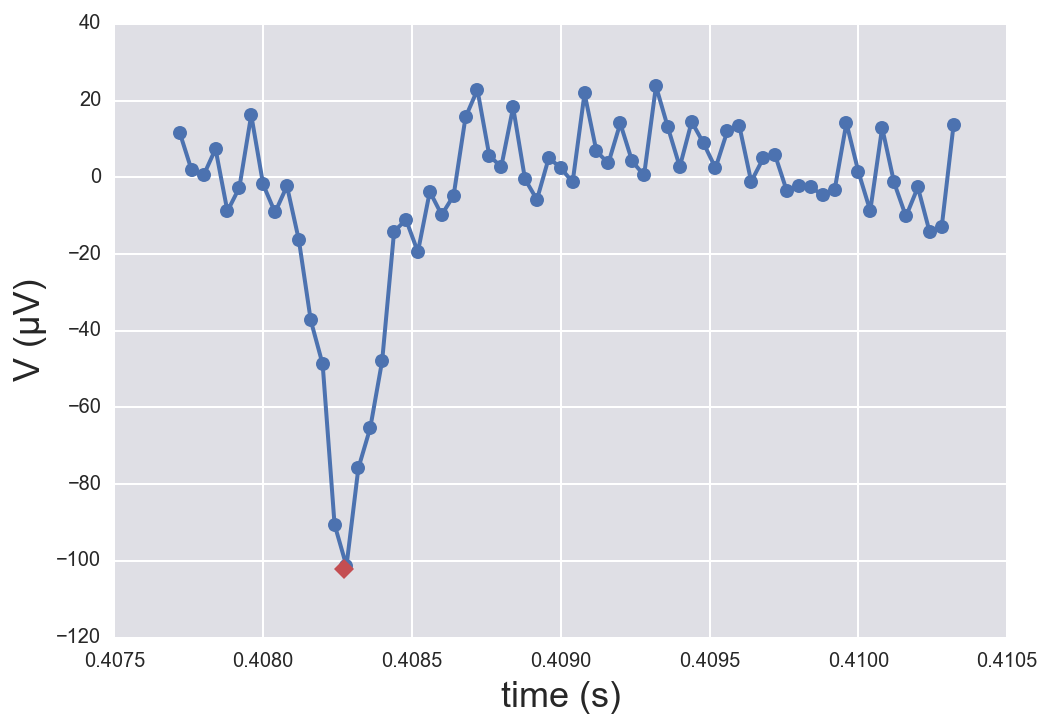

In [22]:
# Find minimum by fitting polynomial
minind = np.argmin(Vs)
V_vals = Vs[minind-1:minind+2]
t_vals = ts[minind-1:minind+2]
a, b, c = np.polyfit(t_vals, V_vals, 2)
t_min = -b / 2 / a

# Plot the result
plt.plot(ts, Vs, 'o-')
plt.plot(t_min, a*t_min**2 + b*t_min + c, 'D', color=sns.color_palette()[2])
plt.xlabel('time (s)')
plt.ylabel('V (µV)')

So, we'll write a quick function to give our minimum.

In [23]:
def local_min(x, y):
    """
    Locally approximate minimum as quadratic
    and return location of minimum.
    """
    minind = np.argmin(y)
    y_vals = y[minind-1:minind+2]
    x_vals = x[minind-1:minind+2]
    a, b, c = np.polyfit(x_vals, y_vals, 2)
    return -b / 2 / a

## Distribution of spike spacing
We'll now compute the position of all spikes using the local_min function.

In [24]:
# Array to hold spike positions
spikes = np.empty(len(df_spike['spike'].unique()))

# Compute spike positions
for i, spike in enumerate(df_spike['spike'].unique()):
    inds = df_spike['spike'] == spike
    spikes[i] = local_min(df_spike['t (s)'][inds].values, 
                          df_spike['V (µV)'][inds].values)
    
# Compute interspike times
interspike_times = np.diff(spikes)

Now that we have the interspike times, we can plot their distribution.

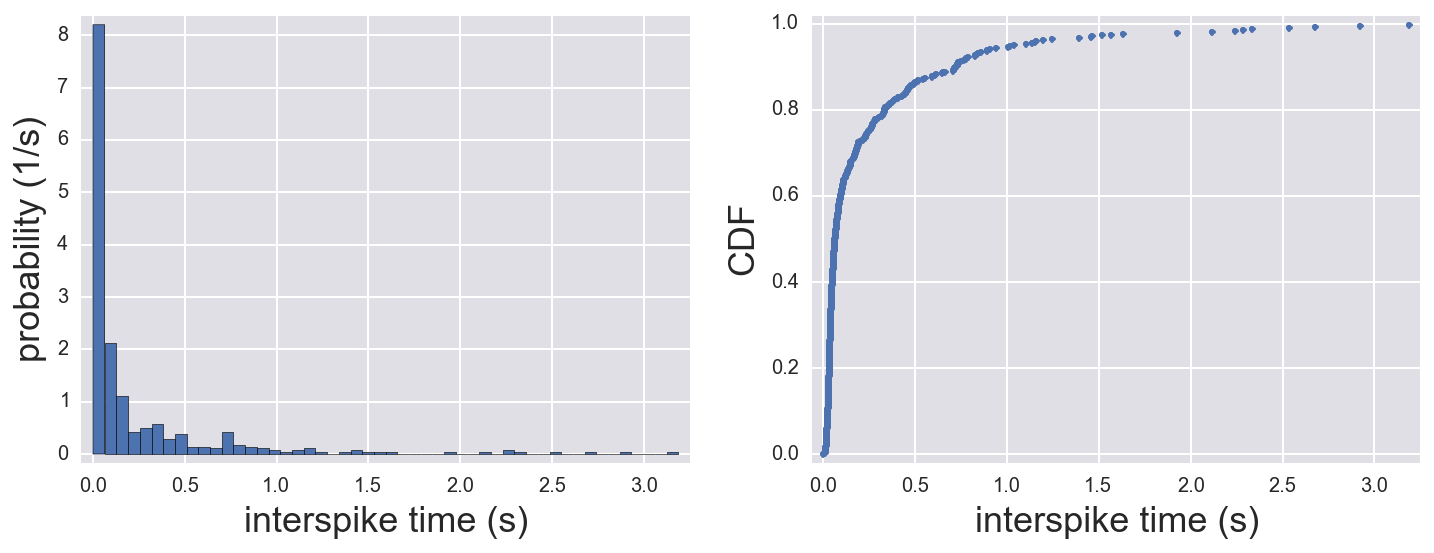

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

# Plot histogram
_ = ax[0].hist(interspike_times, bins=50, normed=True)
ax[0].set_xlabel('interspike time (s)')
ax[0].set_ylabel('probability (1/s)')

# Make ECDF
x = np.sort(interspike_times)
y = np.arange(len(x)) / len(x)
ax[1].plot(x, y, '.')
ax[1].set_xlabel('interspike time (s)')
ax[1].set_ylabel('CDF')

# Clean up
ax[0].margins(0.02)
ax[1].margins(0.02)

The distribution has a long tail.  Many spikes occur in close to each other, and then there are long periods of quiescence.  We could try various models and for MLE to determine parameters, but I leave that as an enrichment exercise for you.